# The Fitz-Hugh Nagumo oscillator

In this notebook, the basic use of the implementation of the Fitz-Hugh Nagumo (`fhn`) model is presented. Usually, the `fhn` model is used to represent a single neuron (for example in `Cakan et al. (2014)`, "Heterogeneous delays in neural networks"). This is due to the difference in timescales of the two equations that define the FHN model: The first equation is often referred to as the "vast variable" whereas the second one is the "slow variable". This makes it possible to creat a model with a very fast spiking mechanism but with a slow refractory period. 

In our case, we are using a parameterization of the `fhn` model that is not quite as usual. Inspired by the paper by `Kostova et al. (2004)` "FitzHugh–Nagumo revisited: Types of bifurcations, periodical forcing and stability regions by a Lyapunov functional.", the implementation in `neurolib` produces a slowly oscillating dynamics and has the advantage to incorporate an external input term that causes a Hopf bifurcation. This means, that the model roughly approximates the behaviour of the `aln` model: For low input values, there is a low-activity fixed point, for intermediate inputs, there is an oscillatory region, and for high input values, the system is in a high-activity fixed point. Thus, it offers a simple way of exploring the dynamics of a neural mass model with these properties, such as the `aln` model.

We want to start by producing a bifurcation diagram of a single node. With `neurolib`, this can be done with a couple of lines of code, as seen further below.

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [3]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np

# Let's import the fhn model
from neurolib.models.fhn import FHNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

# Single node simulation

In [22]:
fhn = FHNModel()
fhn.params['duration'] = 2.0*1000

Let's draw a simple one-dimensional bifurcation diagram of this model to orient ourselves in the parameter space

In [23]:
max_x = []
min_x = []
# these are the different input values that we want to scan
x_inputs = np.linspace(0, 2, 50)
for x_ext in x_inputs:
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    fhn.params['x_ext'] = [x_ext]
    fhn.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_x.append(np.max(fhn.x[0, -int(1000/fhn.params['dt']):]))
    min_x.append(np.min(fhn.x[0, -int(1000/fhn.params['dt']):]))

Text(0, 0.5, 'Min / max x')

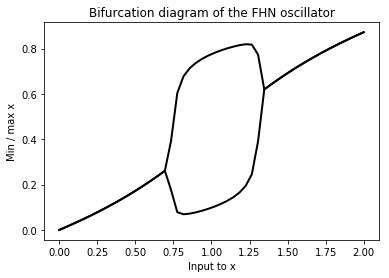

In [24]:
plt.plot(x_inputs, max_x, c='k', lw = 2)
plt.plot(x_inputs, min_x, c='k', lw = 2)
plt.title("Bifurcation diagram of the FHN oscillator")
plt.xlabel("Input to x")
plt.ylabel("Min / max x")

In this model, there is a Hopf bifurcation happening at two input values. We can see the oscillatory region at input values from roughly `0.75` to `1.3`.

# Brain network

In [96]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [97]:
fhn = FHNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

In [113]:
fhn.params['duration'] = 10 * 1000 
# add some noise
fhn.params['sigma_ou'] = .01
# set the global coupling strenght of the brain network
fhn.params['K_gl'] = 1.0
# let's put all nodes close to the limit cycle such that
# noise can kick them in and out of the oscillation
# all nodes get the same constant input
fhn.params['x_ext'] = [0.72] * fhn.params['N']

fhn.run(chunkwise=True, append_outputs=True)

Text(0.5, 0, 't [ms]')

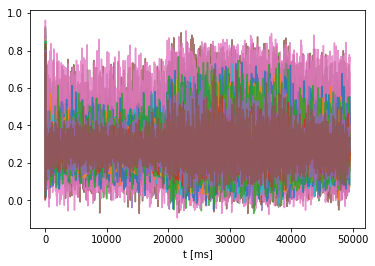

In [114]:
plt.plot(fhn.t, fhn.x[::5, :].T, alpha=0.8);
plt.xlabel("t [ms]")

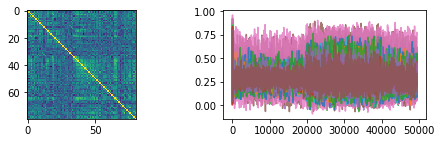

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].imshow(func.fc(fhn.x[:, -10000:]))
axs[1].plot(fhn.t, fhn.x[::5, :].T, alpha=0.8);

In [116]:
scores = []
for i in range(len(ds.FCs)):
    fc_score = func.matrix_correlation(func.fc(fhn.x[:, -int(5000/fhn.params['dt']):]), ds.FCs[i])
    scores.append(fc_score)
    print("Dataset {} correlation: {:.2f}". format(i, fc_score))
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Dataset 0 correlation: 0.42
Dataset 1 correlation: 0.51
Dataset 2 correlation: 0.52
Dataset 3 correlation: 0.47
Dataset 4 correlation: 0.48
Dataset 5 correlation: 0.44
Dataset 6 correlation: 0.54
Mean FC/FC correlation: 0.48
